In [3]:
import sys
sys.path.append('./RECOTOOLS/')
# import project_metadata
from core import system_run, survey_metadata, run_collection, feature_collection
import datalibrary
import processor
import systems.pelisystem
import systems.balgraysystem
from pandas_tools import *
from mugrass.units import *
from mugrass.voxelframe_meshgrid import *

import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate 
import scipy

In [4]:
# First build our voxel meshgrid
minx = 0*m
maxx =  130*m # ROI + a bit
nx   = int((maxx-minx)/(1*m))

miny = -30*m
maxy =  30*m 
ny   = int((maxy-miny)/(1*m))

minz = 0*m
maxz = 55*m # Check how deep tunnel is in script 1
nz   = int((maxz-minz)/(1*m))

grid = voxelframe_meshgrid( xx=np.linspace(minx,maxx,nx),
                            yy=np.linspace(miny,maxy,ny),
                            zz=np.linspace(minz,maxz,nz) )

# Call expand to fill in edges (increases memory consumption)
grid.Expand()

# If no terrain masking (next cell) desired, save this grid to a vxl file at this point
#grid.Write("voxel_dataframe.vxl")

In [6]:

# If there is an offset in the terrain apply it here
offset=0*m


tunnel_height = 6*m # radius
tunnel_width = 9*m/2 # radius
grid.df["in_tunnel"] = ((grid.df.y/tunnel_width)**2 + (grid.df.z/tunnel_height)**2) < 1.0


# Load GIS Model

gis_model = pd.read_csv("GIS/generated_gis_model.csv")
gis_model.X = gis_model.X*m + offset
gis_model.Y = gis_model.Y*m
gis_model.DTM = gis_model.DTM_gradcorr*m 


gis_model_cut = gis_model[ (gis_model.X > minx-10*m) &
                       (gis_model.X < maxx+10*m) & 
                       (gis_model.Y > miny-1*m) & 
                       (gis_model.Y < maxy+1*m) ]

#gis_model_cut.X=gis_model.X - centre_position
gis_model_cut.Y=gis_model.Y

gis_model_cut = gis_model_cut.groupby(["X","Y"]).mean().reset_index()

grid.df["DTM_height"] = scipy.interpolate.griddata(
        np.array([gis_model_cut.X, gis_model_cut.Y]).transpose(),
        gis_model_cut.DTM,
        np.array([grid.df.x, grid.df.y]).transpose()
    )

grid.df["above_surface"] = grid.df.zu > grid.df["DTM_height"]


grid_masked = grid.df.loc[ (grid.df.in_tunnel==False) & (grid.df.above_surface==False) ]

grid_masked.reset_index(drop=True, inplace=True)

grid_masked_collection=voxelframe_meshgrid(voxel_df=grid_masked,config_dict={})

#grid_masked_collection.Expand()

grid_masked_collection.Write("voxel_dataframe_masked.vxl")



/tmp/ipykernel_71233/1522991754.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gis_model_cut.Y=gis_model.Y


Saving Voxel Collection to  voxel_dataframe_masked.vxl


/tmp/ipykernel_71233/1694767888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_masked_collection.df.value=2.65*g/cm3
/tmp/ipykernel_71233/1694767888.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_masked_collection.df["initial_guess"] = grid_masked_collection.df["value"]


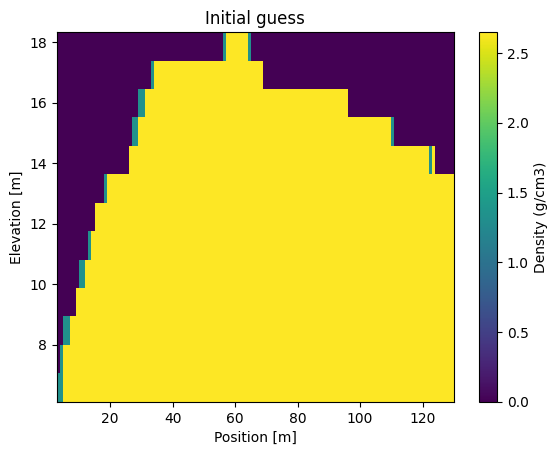

In [7]:
grid_masked_collection.df.value=2.65*g/cm3
grid_masked_collection.df.loc[grid_masked_collection.df.above_surface, "value"] = 0.0
grid_masked_collection.df.loc[grid_masked_collection.df.in_tunnel, "value"] = 0.0

grid_masked_collection.df["initial_guess"] = grid_masked_collection.df["value"]

slice = grid_masked_collection.df[ np.abs(grid_masked_collection.df.y) < 1*m ]

plt.hist2d(x=(slice.x)/m, y=slice.z/m, weights=(slice.initial_guess/len(np.unique(slice.y)))/(g/cm3), bins=[len(np.unique(slice.x)),len(np.unique(slice.z))])
plt.title("Initial guess")
plt.xlabel("Position [m]")
plt.ylabel("Elevation [m]")
plt.colorbar(label="Density (g/cm3)")
plt.show()